## List of contents
1. 327_3 / cl0.5 / idc0.4 / ep5 / bz1024 / ldtv2
2. 327_3 / cl0.5 / idc0.5 / ep5 / bz2048 / ldtv2
3. 327_3 / cl0.5 / idc0.5 / ep15 / bz2048 / ldtv2
4. 327_6ds / cl0.025 / idc0.3 / ep40 / bz1536 / ldtv3
5. 327_6ds / cl0.05 / idc0.5 / ep40 / bz2048 / ldtv3
6. 327_6ds / cl0.1 / idc0.5 / ep40 / bz2048 / ldtv3

In [1]:
import coremlv2 as core
import importlib
importlib.reload(core)
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def epochs_subepochs_progress(folder_list, search_condition):
    '''Return search_results for iter_id 
    
    with format below:
    
    iter_id = f'model-{model_no}-{version}_constituentlimits-{constituent_limits}_idconstituent-{id_constituent}_minvidconstituents-{min_vid_constituents}_epochs-{epochs}_batchsize-{batch_size}_loaddatasetwsdver-{load_dataset_wsd_ver_switcher[load_dataset_wsd_ver][0]}_shufflebuffersize-{shuffle_buffer_size}_generator-{1 if generator else 0}'
    
    with last part is epochs-subepochs progress'''
    search_results = {}
    for fl in folder_list:
        if core.re.search(search_condition, fl):
            progress = fl.split('_')[-1]
            progress_split = tuple(progress.split('-'))
            epochs, sub_epochs = progress_split
            epochs, sub_epochs = int(epochs), int(sub_epochs)
            if epochs not in search_results:
                search_results[epochs] = []
            if sub_epochs not in search_results[epochs]:
                search_results[epochs].append(sub_epochs)
    return search_results

def sort_search_results(search_results):
    '''Valid for search results from 
    `epochs_subepochs_progress` function
    '''
    search_results_keys = list(search_results.keys())
    search_results_keys = [int(i) for i in search_results_keys]
    # print(search_results_keys)
    search_results_keys.sort()
    # print(search_results_keys)
    search_results_sorted = {}
    for search_results_key in search_results_keys:
        search_results_sorted[search_results_key] = sorted(search_results[search_results_key])
        # search_results[search_results_key].sort()
    return search_results_sorted

def model_histories(search_results_sorted, ROOT_PATH, iter_id):
    '''Valid for sorted search results
    
    from `epochs_subepochs_progress`
    '''
    histories = {}
    for epoch in search_results_sorted:
        for sub_epoch in search_results_sorted[epoch]:
            complete_iter_id = f'{iter_id}_{epoch}-{sub_epoch}'
            save_path = core.os.path.join(ROOT_PATH, f'models/preloaded/{complete_iter_id}')
            history_path = core.os.path.join(save_path, 'history.json')
            with open(history_path, 'r') as f:
                history = core.json.load(f)
            if epoch not in histories:
                histories[epoch] = {}
            if sub_epoch not in histories[epoch]:
                histories[epoch][sub_epoch] = history
    return histories

def get_histories_by_iterid(ROOT_PATH, iter_id):
    '''Get sequential histories of
    model progress based on ./[iter_id]/history.json
    '''
    # Search for eligibility in selected folder
    preloaded_folder = core.os.path.join(ROOT_PATH, 'models/preloaded')
    save_path = core.os.path.join(ROOT_PATH, f'models/preloaded/{iter_id}/')
    folder_list = core.os.listdir(preloaded_folder)

    # split, select last entry, split again into epochs-subepochs -> dictionary entry
    search_results = epochs_subepochs_progress(folder_list, iter_id)
    search_results_sorted = sort_search_results(search_results)
    histories = model_histories(search_results_sorted, ROOT_PATH, iter_id)
    return histories

def get_plot_axis_values(histories, metrics=('loss','accuracy'), sets=('', 'val_')):
    # Plotting (2 vertical sub plots with same x axis)
    metric_values = {}
    xticklabels = []
    metric_values_per_epoch = {}
    for epoch in histories:
        for sub_epoch in histories[epoch]:
            for metric in histories[epoch][sub_epoch]:
                if metric not in metric_values:
                    metric_values[metric] = []
                metric_values[metric].append(histories[epoch][sub_epoch][metric][0])

                if metric not in metric_values_per_epoch:
                    metric_values_per_epoch[metric] = {}
                if epoch not in metric_values_per_epoch[metric]:
                    metric_values_per_epoch[metric][epoch] = []
                metric_values_per_epoch[metric][epoch].append(histories[epoch][sub_epoch][metric][0])
            xticklabels.append(f'{epoch}-{sub_epoch}')
    return metric_values, xticklabels, metric_values_per_epoch

def plot_sequential_model_progression(xticklabels, metric_values, subplots=2, figsize=(10,5)):
    '''Work for loss/val_loss/accuracy/val_accuracy
    metrics.
    '''
    fig, axs = plt.subplots(subplots, figsize=figsize, sharex=True)
    fig.suptitle('Sequential model progression')
    axs[0].plot(xticklabels, metric_values['loss'], label='loss')
    axs[0].plot(xticklabels, metric_values['val_loss'], label='val_loss')
    axs[0].set_title('loss')
    axs[0].legend()
    axs[1].plot(xticklabels, metric_values['accuracy'], label='accuracy')
    axs[1].plot(xticklabels, metric_values['val_accuracy'], label='val_accuracy')
    axs[1].set_title('accuracy')
    axs[1].legend()
    plt.tight_layout()
    axs[0].grid(visible=True, which='major')
    axs[1].grid(visible=True, which='major')
    
def plot_epoch_subepoch_progression(metric_values_per_epoch, n_metrics=4, figsize=(10,10)):
    # Plot by epoch/sub-epoch progression
    metrics = list(metric_values_per_epoch.keys())
    fig, axs = plt.subplots(n_metrics, figsize=figsize, sharex=True)
    fig.suptitle('Model progression per epoch')

    for i in range(n_metrics):
        for epoch in metric_values_per_epoch[metrics[i]]:
            axs[i].plot(np.arange(len(metric_values_per_epoch[metrics[i]][epoch])), metric_values_per_epoch[metrics[i]][epoch], label=epoch)
        axs[i].set_title(metrics[i])
        axs[i].legend()
        axs[i].grid(visible=True, which='major')
    plt.tight_layout()

### 327_3 / cl0.5 / idc0.4 / ep5 / bz1024 / ldtv2

In [32]:
model_base_id = '327'
version = '3'
model_no = model_base_id
constituent_limits = 0.5
id_constituent = 1
min_vid_constituents = 0.4
epochs = 5
batch_size = 1024
load_dataset_wsd_ver_switcher = {'1':['1','world data load from test slice'],
                                 '2':['2','world data load from train slice'],}
load_dataset_wsd_ver = '2'
shuffle_buffer_size = 1
generator=True

ROOT_PATH='./'
DB_ROOT_PATH='E:\#PROJECT\idx'
db_ver = '8'

iter_id = f'{model_no}-{version}_cl-{constituent_limits}_idc-{id_constituent}_mid-{min_vid_constituents}_ep-{epochs}_bz-{batch_size}_ldtv-{load_dataset_wsd_ver_switcher[load_dataset_wsd_ver][0]}_sbuffs-{shuffle_buffer_size}_gen-{1 if generator else 0}'
histories = get_histories_by_iterid(ROOT_PATH, iter_id)
metric_values, xticklabels, metric_values_per_epoch = get_plot_axis_values(histories, metrics=('loss', 'accuracy'), sets=('', 'val_'))

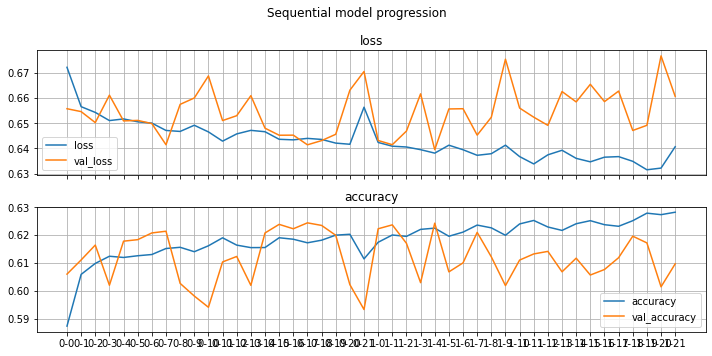

In [30]:
plot_sequential_model_progression(xticklabels, metric_values, subplots=2, figsize=(10,5))

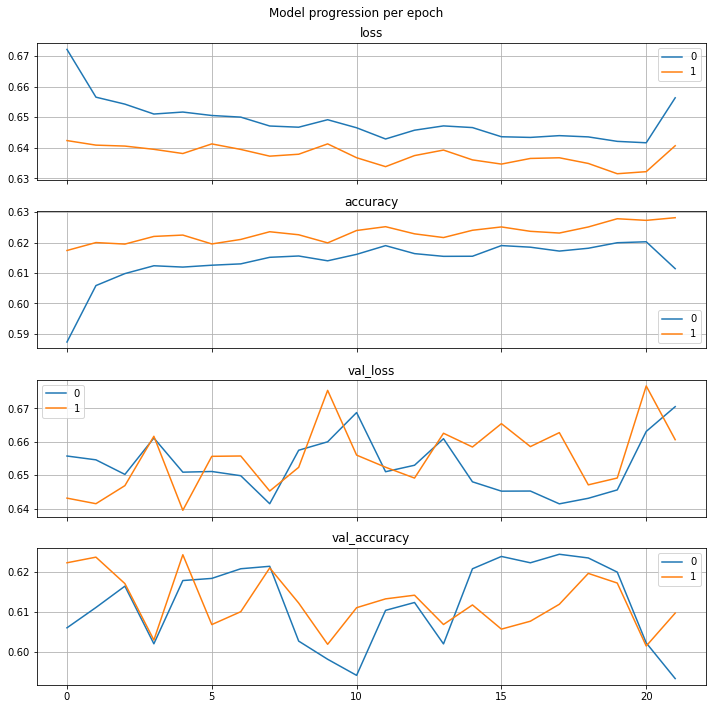

In [31]:
plot_epoch_subepoch_progression(metric_values_per_epoch, n_metrics=4, figsize=(10,10))

### 327_3 / cl0.5 / idc0.5 / ep5 / bz2048 / ldtv2

In [33]:
model_base_id = '327'
version = '3'
model_no = model_base_id
constituent_limits = 0.5
id_constituent = 1
min_vid_constituents = 0.5
epochs = 5
batch_size = 2048
load_dataset_wsd_ver_switcher = {'1':['1','world data load from test slice'],
                                 '2':['2','world data load from train slice'],}
load_dataset_wsd_ver = '2'
shuffle_buffer_size = 1
generator=True

ROOT_PATH='./'
DB_ROOT_PATH='E:\#PROJECT\idx'
db_ver = '8'

iter_id = f'{model_no}-{version}_cl-{constituent_limits}_idc-{id_constituent}_mid-{min_vid_constituents}_ep-{epochs}_bz-{batch_size}_ldtv-{load_dataset_wsd_ver_switcher[load_dataset_wsd_ver][0]}_sbuffs-{shuffle_buffer_size}_gen-{1 if generator else 0}'
histories = get_histories_by_iterid(ROOT_PATH, iter_id)
metric_values, xticklabels, metric_values_per_epoch = get_plot_axis_values(histories, metrics=('loss', 'accuracy'), sets=('', 'val_'))

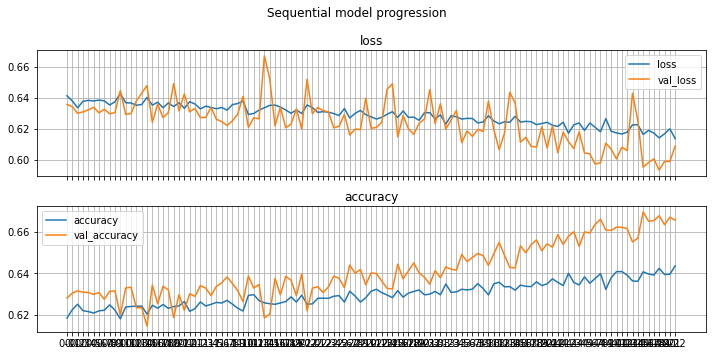

In [34]:
plot_sequential_model_progression(xticklabels, metric_values, subplots=2, figsize=(10,5))

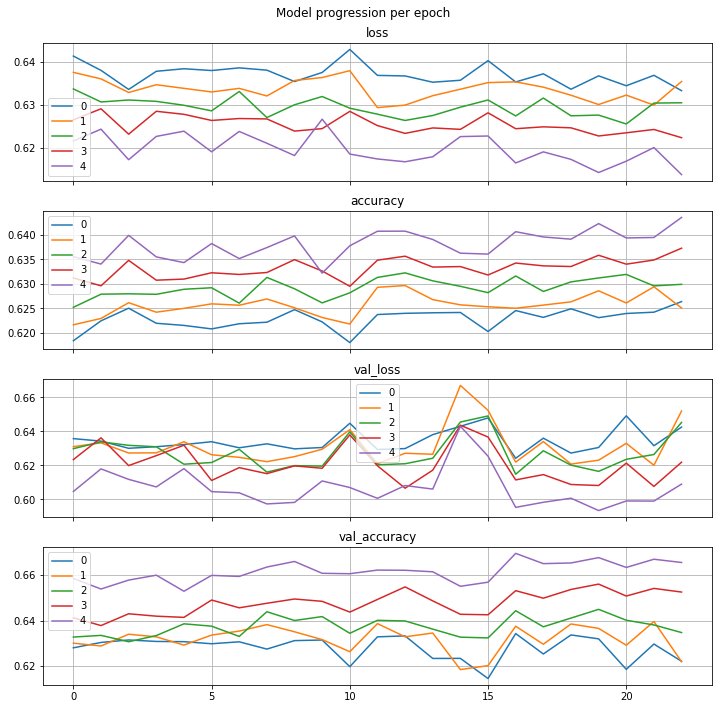

In [35]:
plot_epoch_subepoch_progression(metric_values_per_epoch, n_metrics=4, figsize=(10,10))

### 327_3 / cl0.5 / idc0.5 / ep15 / bz2048 / ldtv2

In [36]:
model_base_id = '327'
version = '3'
model_no = model_base_id
constituent_limits = 0.5
id_constituent = 1
min_vid_constituents = 0.5
epochs = 15
batch_size = 2048
load_dataset_wsd_ver_switcher = {'1':['1','world data load from test slice'],
                                 '2':['2','world data load from train slice'],}
load_dataset_wsd_ver = '2'
shuffle_buffer_size = 1
generator=True

ROOT_PATH='./'
DB_ROOT_PATH='E:\#PROJECT\idx'
db_ver = '8'

iter_id = f'{model_no}-{version}_cl-{constituent_limits}_idc-{id_constituent}_mid-{min_vid_constituents}_ep-{epochs}_bz-{batch_size}_ldtv-{load_dataset_wsd_ver_switcher[load_dataset_wsd_ver][0]}_sbuffs-{shuffle_buffer_size}_gen-{1 if generator else 0}'
histories = get_histories_by_iterid(ROOT_PATH, iter_id)
metric_values, xticklabels, metric_values_per_epoch = get_plot_axis_values(histories, metrics=('loss', 'accuracy'), sets=('', 'val_'))

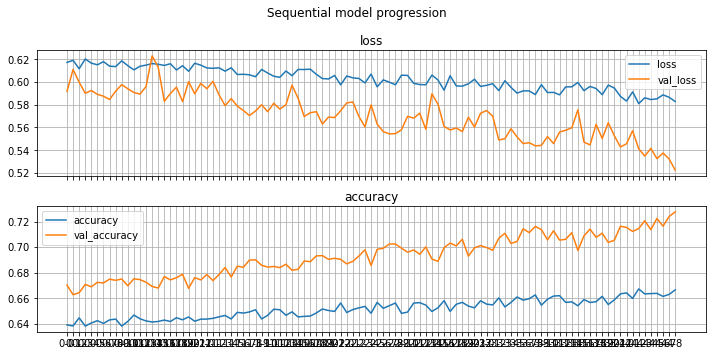

In [37]:
plot_sequential_model_progression(xticklabels, metric_values, subplots=2, figsize=(10,5))

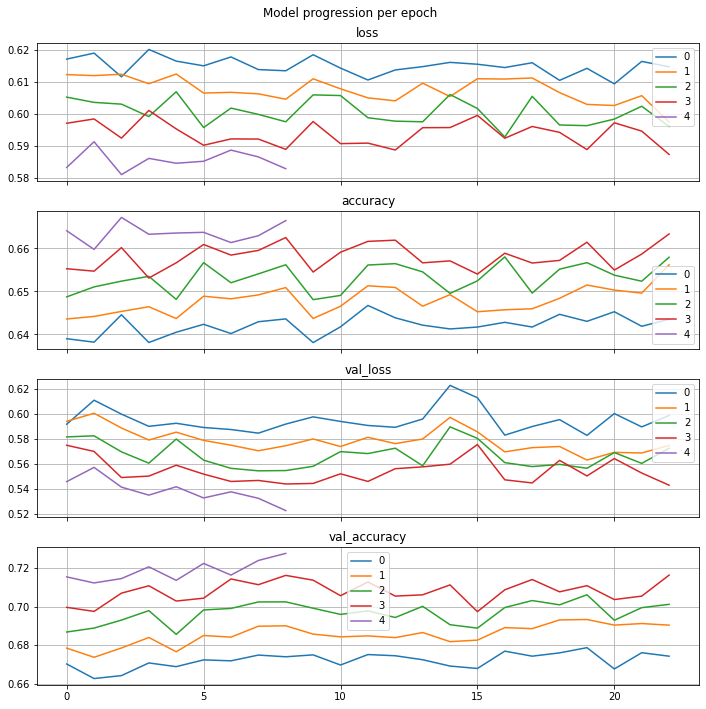

In [38]:
plot_epoch_subepoch_progression(metric_values_per_epoch, n_metrics=4, figsize=(10,10))

### 327_6ds / cl0.025 / idc0.3 / ep40 / bz1536 / ldtv3

In [39]:
model_base_id = '327'
version = '6ds'
model_no = model_base_id
constituent_limits = 0.025
id_constituent = 1
min_vid_constituents = 0.3
epochs = 40
batch_size = 1536
load_dataset_wsd_ver_switcher = {'1':['1','world data load from test slice'],
                                 '2':['2','world data load from train slice'],
                                 '3':['3','validation data from test set'],}
load_dataset_wsd_ver = '3'
shuffle_buffer_size = 1
generator=True

ROOT_PATH='./'
DB_ROOT_PATH='E:\#PROJECT\idx'
db_ver = '8'

iter_id = f'{model_no}-{version}_cl-{constituent_limits}_idc-{id_constituent}_mid-{min_vid_constituents}_ep-{epochs}_bz-{batch_size}_ldtv-{load_dataset_wsd_ver_switcher[load_dataset_wsd_ver][0]}_sbuffs-{shuffle_buffer_size}_gen-{1 if generator else 0}'
histories = get_histories_by_iterid(ROOT_PATH, iter_id)
metric_values, xticklabels, metric_values_per_epoch = get_plot_axis_values(histories, metrics=('loss', 'accuracy'), sets=('', 'val_'))

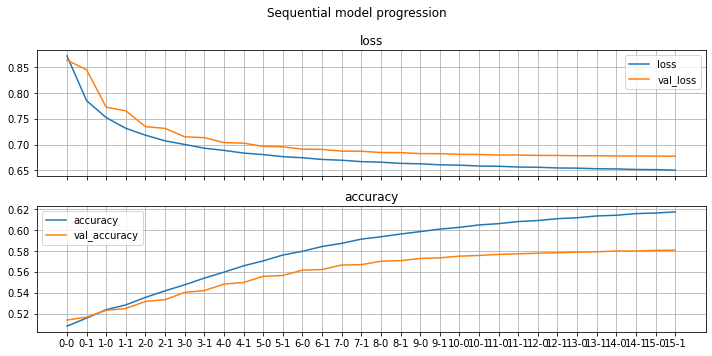

In [40]:
plot_sequential_model_progression(xticklabels, metric_values, subplots=2, figsize=(10,5))

### 327_6ds / cl0.05 / idc0.5 / ep40 / bz2048 / ldtv3

In [42]:
model_base_id = '327'
version = '6ds'
model_no = model_base_id
constituent_limits = 0.05
id_constituent = 1
min_vid_constituents = 0.5
epochs = 40
batch_size = 2048
load_dataset_wsd_ver_switcher = {'1':['1','world data load from test slice'],
                                 '2':['2','world data load from train slice'],
                                 '3':['3','validation data from test set'],}
load_dataset_wsd_ver = '3'
shuffle_buffer_size = 1
generator=True

ROOT_PATH='./'
DB_ROOT_PATH='E:\#PROJECT\idx'
db_ver = '8'

iter_id = f'{model_no}-{version}_cl-{constituent_limits}_idc-{id_constituent}_mid-{min_vid_constituents}_ep-{epochs}_bz-{batch_size}_ldtv-{load_dataset_wsd_ver_switcher[load_dataset_wsd_ver][0]}_sbuffs-{shuffle_buffer_size}_gen-{1 if generator else 0}'
histories = get_histories_by_iterid(ROOT_PATH, iter_id)
metric_values, xticklabels, metric_values_per_epoch = get_plot_axis_values(histories, metrics=('loss', 'accuracy'), sets=('', 'val_'))

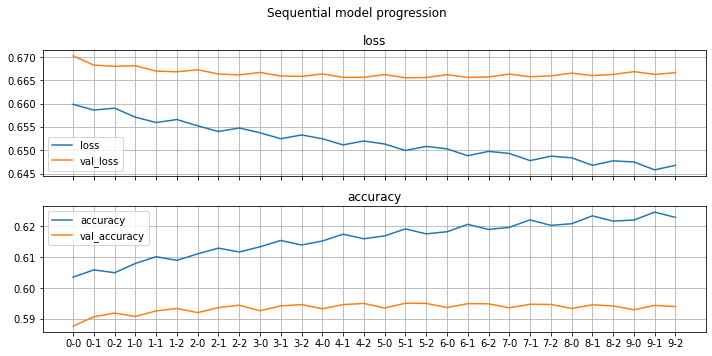

In [43]:
plot_sequential_model_progression(xticklabels, metric_values, subplots=2, figsize=(10,5))

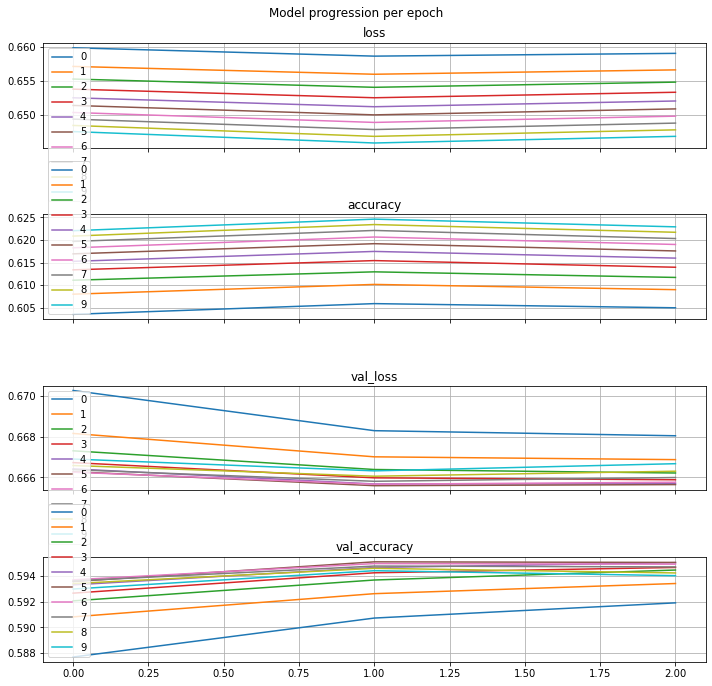

In [44]:
plot_epoch_subepoch_progression(metric_values_per_epoch, n_metrics=4, figsize=(10,10))

### 327_6ds / cl0.1 / idc0.5 / ep40 / bz2048 / ldtv3

In [45]:
model_base_id = '327'
version = '6ds'
model_no = model_base_id
constituent_limits = 0.1
id_constituent = 1
min_vid_constituents = 0.5
epochs = 40
batch_size = 2048
load_dataset_wsd_ver_switcher = {'1':['1','world data load from test slice'],
                                 '2':['2','world data load from train slice'],
                                 '3':['3','validation data from test set'],}
load_dataset_wsd_ver = '3'
shuffle_buffer_size = 1
generator=True

ROOT_PATH='./'
DB_ROOT_PATH='E:\#PROJECT\idx'
db_ver = '8'

iter_id = f'{model_no}-{version}_cl-{constituent_limits}_idc-{id_constituent}_mid-{min_vid_constituents}_ep-{epochs}_bz-{batch_size}_ldtv-{load_dataset_wsd_ver_switcher[load_dataset_wsd_ver][0]}_sbuffs-{shuffle_buffer_size}_gen-{1 if generator else 0}'
histories = get_histories_by_iterid(ROOT_PATH, iter_id)
metric_values, xticklabels, metric_values_per_epoch = get_plot_axis_values(histories, metrics=('loss', 'accuracy'), sets=('', 'val_'))

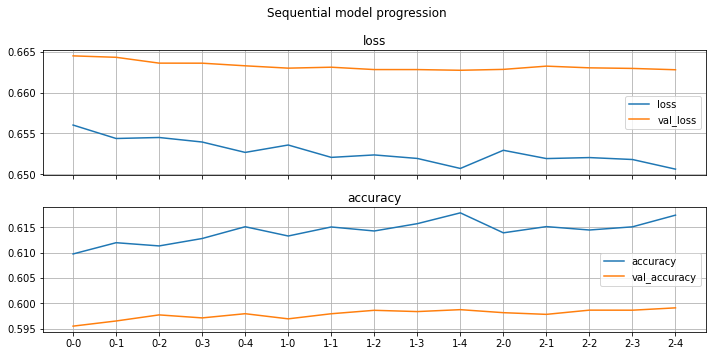

In [46]:
plot_sequential_model_progression(xticklabels, metric_values, subplots=2, figsize=(10,5))

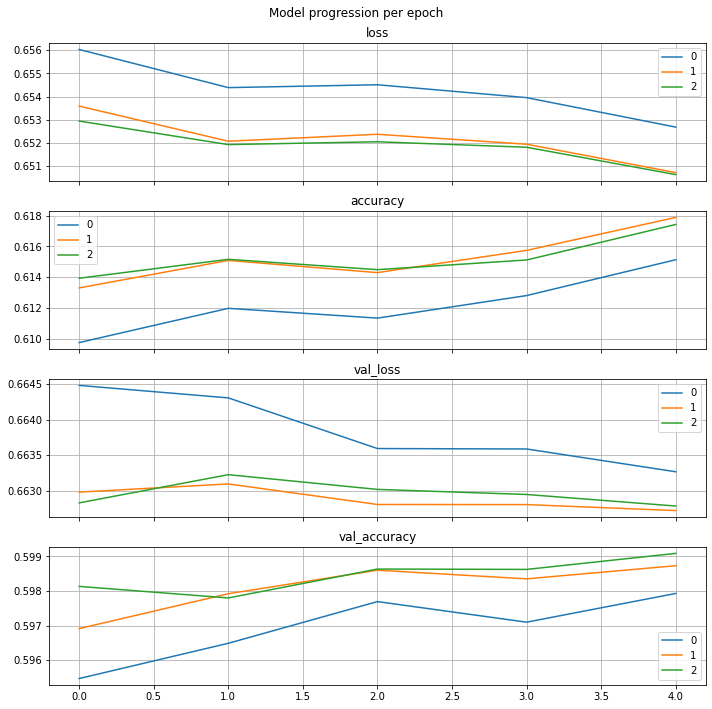

In [47]:
plot_epoch_subepoch_progression(metric_values_per_epoch, n_metrics=4, figsize=(10,10))

In [54]:
model_base_id = '327'
version = '8'
model_no = model_base_id
constituent_limits = 0.005
id_constituent = 1
min_vid_constituents = 0.9
epochs = 40
batch_size = 2048
load_dataset_wsd_ver_switcher = {'1':['1','world data load from test slice'],
                                 '2':['2','world data load from train slice'],
                                 '3':['3','validation data from test set'],}
load_dataset_wsd_ver = '3'
shuffle_buffer_size = 1
generator=True

ROOT_PATH='./'
DB_ROOT_PATH='E:\#PROJECT\idx'
db_ver = '8'

iter_id = f'{model_no}-{version}_cl-{constituent_limits}_idc-{id_constituent}_mid-{min_vid_constituents}_ep-{epochs}_bz-{batch_size}_ldtv-{load_dataset_wsd_ver_switcher[load_dataset_wsd_ver][0]}_sbuffs-{shuffle_buffer_size}_gen-{1 if generator else 0}'
histories = get_histories_by_iterid(ROOT_PATH, iter_id)
metric_values, xticklabels, metric_values_per_epoch = get_plot_axis_values(histories, metrics=('loss', 'accuracy'), sets=('', 'val_'))

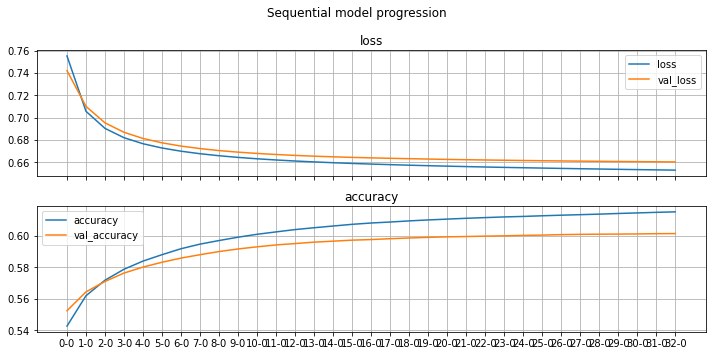

In [55]:
plot_sequential_model_progression(xticklabels, metric_values, subplots=2, figsize=(10,5))

In [56]:
model_base_id = '327'
version = '9'
model_no = model_base_id
constituent_limits = 0.005
id_constituent = 1
min_vid_constituents = 0.9
epochs = 40
batch_size = 2048
load_dataset_wsd_ver_switcher = {'1':['1','world data load from test slice'],
                                 '2':['2','world data load from train slice'],
                                 '3':['3','validation data from test set'],}
load_dataset_wsd_ver = '3'
shuffle_buffer_size = 1
generator=True

ROOT_PATH='./'
DB_ROOT_PATH='E:\#PROJECT\idx'
db_ver = '8'

iter_id = f'{model_no}-{version}_cl-{constituent_limits}_idc-{id_constituent}_mid-{min_vid_constituents}_ep-{epochs}_bz-{batch_size}_ldtv-{load_dataset_wsd_ver_switcher[load_dataset_wsd_ver][0]}_sbuffs-{shuffle_buffer_size}_gen-{1 if generator else 0}'
histories = get_histories_by_iterid(ROOT_PATH, iter_id)
metric_values, xticklabels, metric_values_per_epoch = get_plot_axis_values(histories, metrics=('loss', 'accuracy'), sets=('', 'val_'))

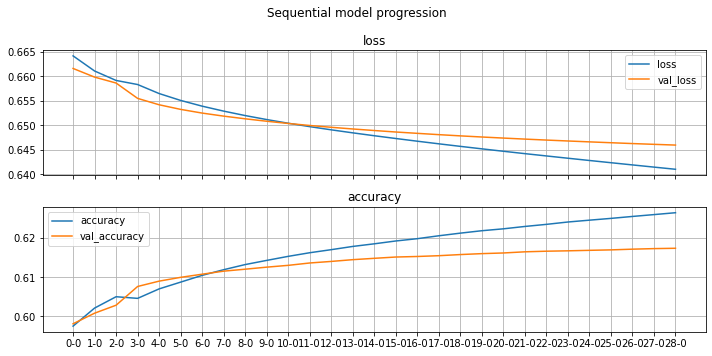

In [57]:
plot_sequential_model_progression(xticklabels, metric_values, subplots=2, figsize=(10,5))

In [12]:
model_base_id = '327'
version = '10'
model_no = model_base_id
constituent_limits = 0.2
id_constituent = 1
min_vid_constituents = 0.5
epochs = 40
batch_size = 512
load_dataset_wsd_ver_switcher = {'1':['1','world data load from test slice'],
                                 '2':['2','world data load from train slice'],
                                 '3':['3','validation data from test set'],}
load_dataset_wsd_ver = '3'
shuffle_buffer_size = 1
generator=True

ROOT_PATH='./'
DB_ROOT_PATH='E:\#PROJECT\idx'
db_ver = '8'

iter_id = f'{model_no}-{version}_cl-{constituent_limits}_idc-{id_constituent}_mid-{min_vid_constituents}_ep-{epochs}_bz-{batch_size}_ldtv-{load_dataset_wsd_ver_switcher[load_dataset_wsd_ver][0]}_sbuffs-{shuffle_buffer_size}_gen-{1 if generator else 0}'
histories = get_histories_by_iterid(ROOT_PATH, iter_id)
metric_values, xticklabels, metric_values_per_epoch = get_plot_axis_values(histories, metrics=('loss', 'accuracy'), sets=('', 'val_'))

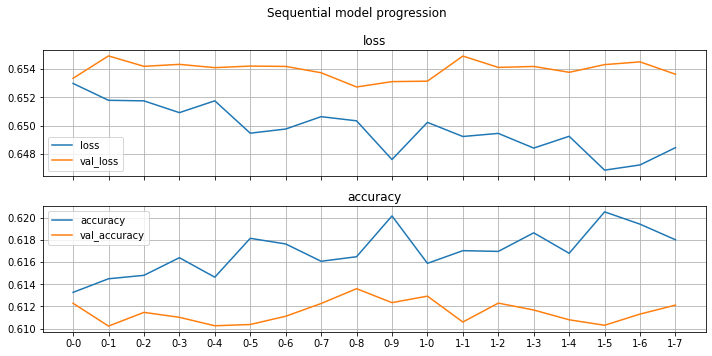

In [13]:
plot_sequential_model_progression(xticklabels, metric_values, subplots=2, figsize=(10,5))

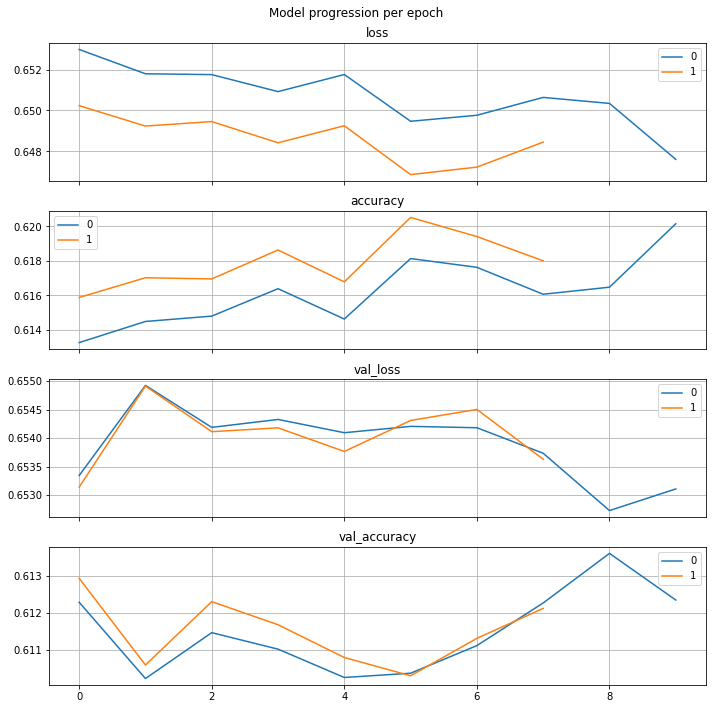

In [14]:
plot_epoch_subepoch_progression(metric_values_per_epoch, n_metrics=4, figsize=(10,10))

In [15]:
model_base_id = '327'
version = '9'
model_no = model_base_id
constituent_limits = 0.1
id_constituent = 1
min_vid_constituents = 0.5
epochs = 40
batch_size = 512
load_dataset_wsd_ver_switcher = {'1':['1','world data load from test slice'],
                                 '2':['2','world data load from train slice'],
                                 '3':['3','validation data from test set'],}
load_dataset_wsd_ver = '3'
shuffle_buffer_size = 1
generator=True

ROOT_PATH='./'
DB_ROOT_PATH='E:\#PROJECT\idx'
db_ver = '8'

iter_id = f'{model_no}-{version}_cl-{constituent_limits}_idc-{id_constituent}_mid-{min_vid_constituents}_ep-{epochs}_bz-{batch_size}_ldtv-{load_dataset_wsd_ver_switcher[load_dataset_wsd_ver][0]}_sbuffs-{shuffle_buffer_size}_gen-{1 if generator else 0}'
histories = get_histories_by_iterid(ROOT_PATH, iter_id)
metric_values, xticklabels, metric_values_per_epoch = get_plot_axis_values(histories, metrics=('loss', 'accuracy'), sets=('', 'val_'))

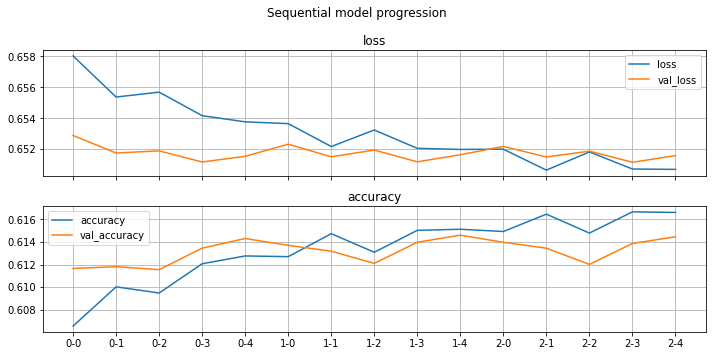

In [16]:
plot_sequential_model_progression(xticklabels, metric_values, subplots=2, figsize=(10,5))

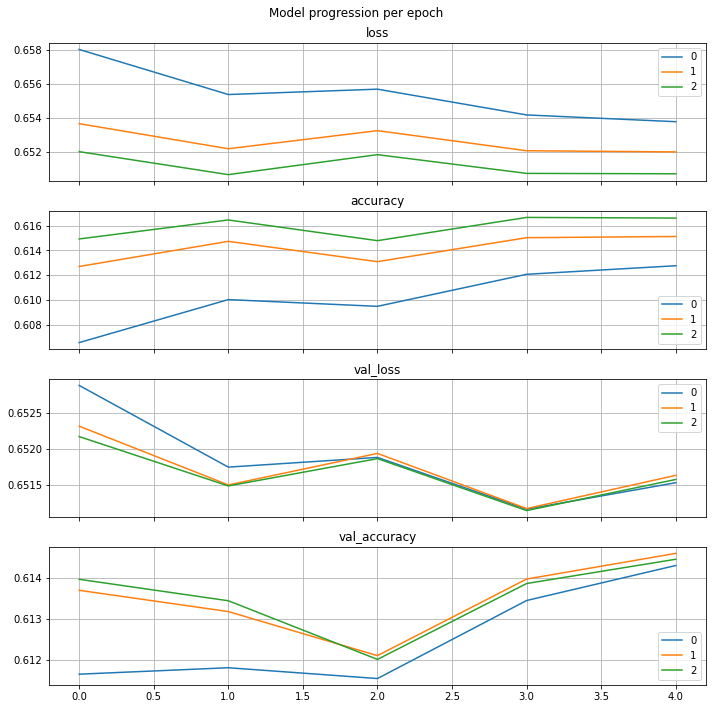

In [17]:
plot_epoch_subepoch_progression(metric_values_per_epoch, n_metrics=4, figsize=(10,10))

In [51]:
model_base_id = '327'
version = '9'
model_no = model_base_id
constituent_limits = 0.1
id_constituent = 1
min_vid_constituents = 0.9
epochs = 40
batch_size = 2048
load_dataset_wsd_ver_switcher = {'1':['1','world data load from test slice'],
                                 '2':['2','world data load from train slice'],
                                 '3':['3','validation data from test set'],}
load_dataset_wsd_ver = '3'
shuffle_buffer_size = 1
generator=True

ROOT_PATH='./'
DB_ROOT_PATH='E:\#PROJECT\idx'
db_ver = '8'

iter_id = f'{model_no}-{version}_cl-{constituent_limits}_idc-{id_constituent}_mid-{min_vid_constituents}_ep-{epochs}_bz-{batch_size}_ldtv-{load_dataset_wsd_ver_switcher[load_dataset_wsd_ver][0]}_sbuffs-{shuffle_buffer_size}_gen-{1 if generator else 0}'
histories = get_histories_by_iterid(ROOT_PATH, iter_id)
metric_values, xticklabels, metric_values_per_epoch = get_plot_axis_values(histories, metrics=('loss', 'accuracy'), sets=('', 'val_'))

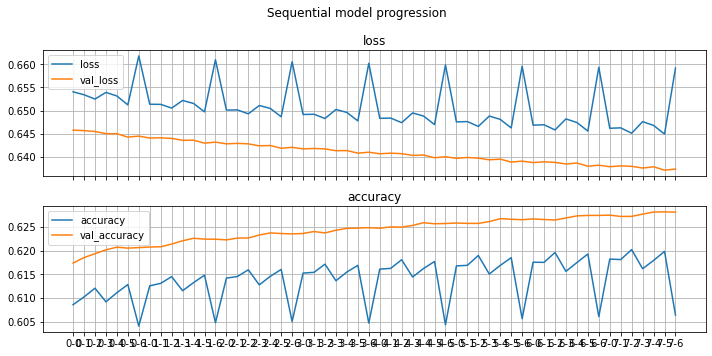

In [52]:
plot_sequential_model_progression(xticklabels, metric_values, subplots=2, figsize=(10,5))

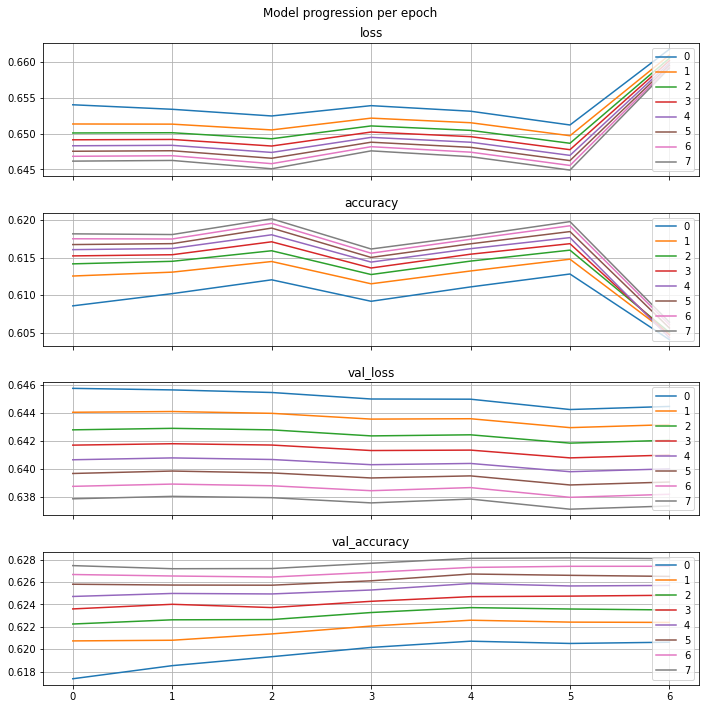

In [53]:
plot_epoch_subepoch_progression(metric_values_per_epoch, n_metrics=4, figsize=(10,10))

In [111]:
model_base_id = '327'
version = '9'
model_no = model_base_id
constituent_limits = 0.15
id_constituent = 1
min_vid_constituents = 0.9
epochs = 40
batch_size = 2048
load_dataset_wsd_ver_switcher = {'1':['1','world data load from test slice'],
                                 '2':['2','world data load from train slice'],
                                 '3':['3','validation data from test set'],}
load_dataset_wsd_ver = '3'
shuffle_buffer_size = 1
generator=True

ROOT_PATH='./'
DB_ROOT_PATH='E:\#PROJECT\idx'
db_ver = '8'

iter_id = f'{model_no}-{version}_cl-{constituent_limits}_idc-{id_constituent}_mid-{min_vid_constituents}_ep-{epochs}_bz-{batch_size}_ldtv-{load_dataset_wsd_ver_switcher[load_dataset_wsd_ver][0]}_sbuffs-{shuffle_buffer_size}_gen-{1 if generator else 0}'
histories = get_histories_by_iterid(ROOT_PATH, iter_id)
metric_values, xticklabels, metric_values_per_epoch = get_plot_axis_values(histories, metrics=('loss', 'accuracy'), sets=('', 'val_'))

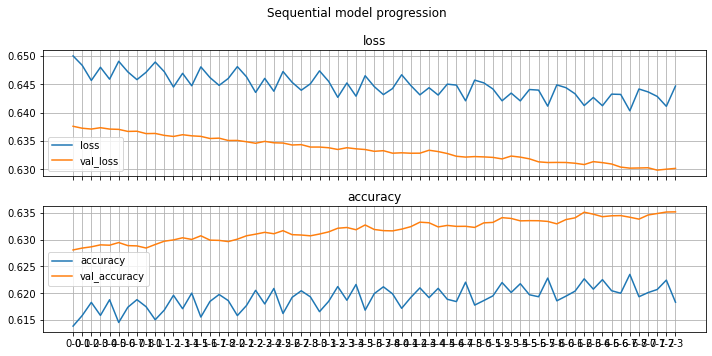

In [112]:
plot_sequential_model_progression(xticklabels, metric_values, subplots=2, figsize=(10,5))

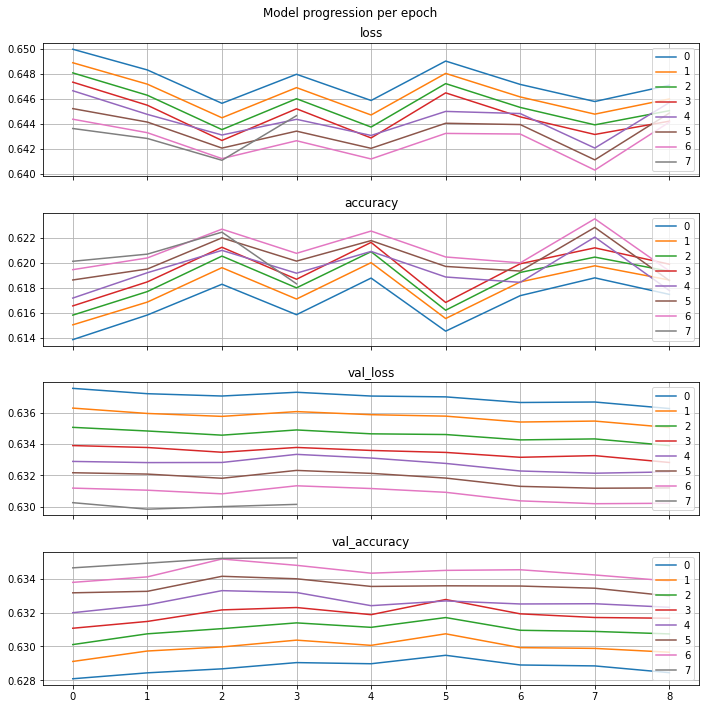

In [113]:
plot_epoch_subepoch_progression(metric_values_per_epoch, n_metrics=4, figsize=(10,10))

In [163]:
model_base_id = '327'
version = '9'
model_no = model_base_id
constituent_limits = 0.2
id_constituent = 1
min_vid_constituents = 0.9
epochs = 40
batch_size = 2048
load_dataset_wsd_ver_switcher = {'1':['1','world data load from test slice'],
                                 '2':['2','world data load from train slice'],
                                 '3':['3','validation data from test set'],}
load_dataset_wsd_ver = '3'
shuffle_buffer_size = 1
generator=True

ROOT_PATH='./'
DB_ROOT_PATH='E:\#PROJECT\idx'
db_ver = '8'

iter_id = f'{model_no}-{version}_cl-{constituent_limits}_idc-{id_constituent}_mid-{min_vid_constituents}_ep-{epochs}_bz-{batch_size}_ldtv-{load_dataset_wsd_ver_switcher[load_dataset_wsd_ver][0]}_sbuffs-{shuffle_buffer_size}_gen-{1 if generator else 0}'
histories = get_histories_by_iterid(ROOT_PATH, iter_id)
metric_values, xticklabels, metric_values_per_epoch = get_plot_axis_values(histories, metrics=('loss', 'accuracy'), sets=('', 'val_'))

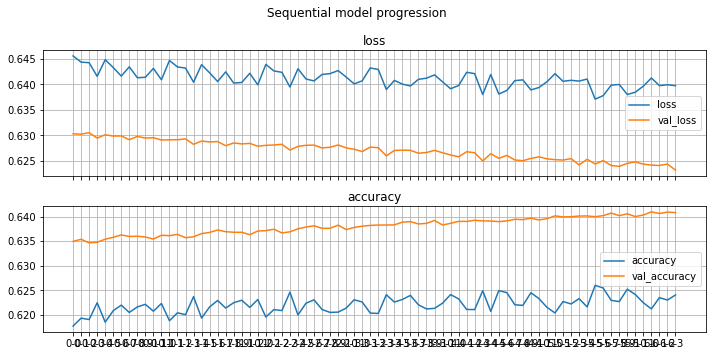

In [164]:
plot_sequential_model_progression(xticklabels, metric_values, subplots=2, figsize=(10,5))

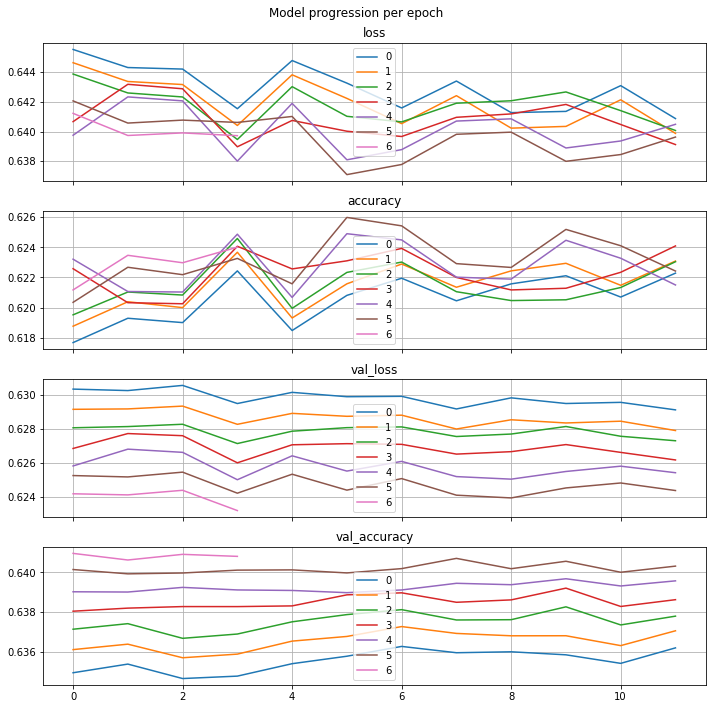

In [165]:
plot_epoch_subepoch_progression(metric_values_per_epoch, n_metrics=4, figsize=(10,10))

In [184]:
model_base_id = '327'
version = '9'
model_no = model_base_id
constituent_limits = 0.25
id_constituent = 1
min_vid_constituents = 0.8
epochs = 40
batch_size = 2048
load_dataset_wsd_ver_switcher = {'1':['1','world data load from test slice'],
                                 '2':['2','world data load from train slice'],
                                 '3':['3','validation data from test set'],}
load_dataset_wsd_ver = '3'
shuffle_buffer_size = 1
generator=True

ROOT_PATH='./'
DB_ROOT_PATH='E:\#PROJECT\idx'
db_ver = '8'

iter_id = f'{model_no}-{version}_cl-{constituent_limits}_idc-{id_constituent}_mid-{min_vid_constituents}_ep-{epochs}_bz-{batch_size}_ldtv-{load_dataset_wsd_ver_switcher[load_dataset_wsd_ver][0]}_sbuffs-{shuffle_buffer_size}_gen-{1 if generator else 0}'
histories = get_histories_by_iterid(ROOT_PATH, iter_id)
metric_values, xticklabels, metric_values_per_epoch = get_plot_axis_values(histories, metrics=('loss', 'accuracy'), sets=('', 'val_'))

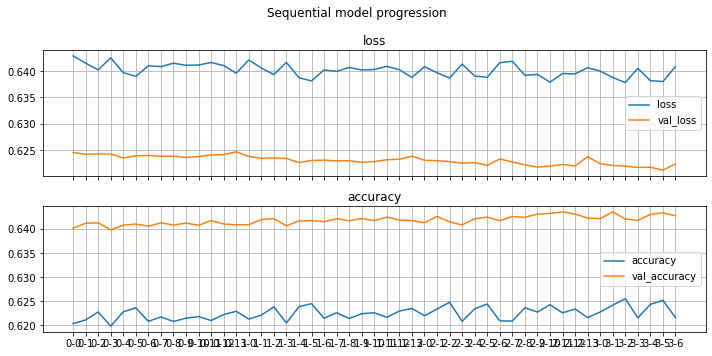

In [185]:
plot_sequential_model_progression(xticklabels, metric_values, subplots=2, figsize=(10,5))

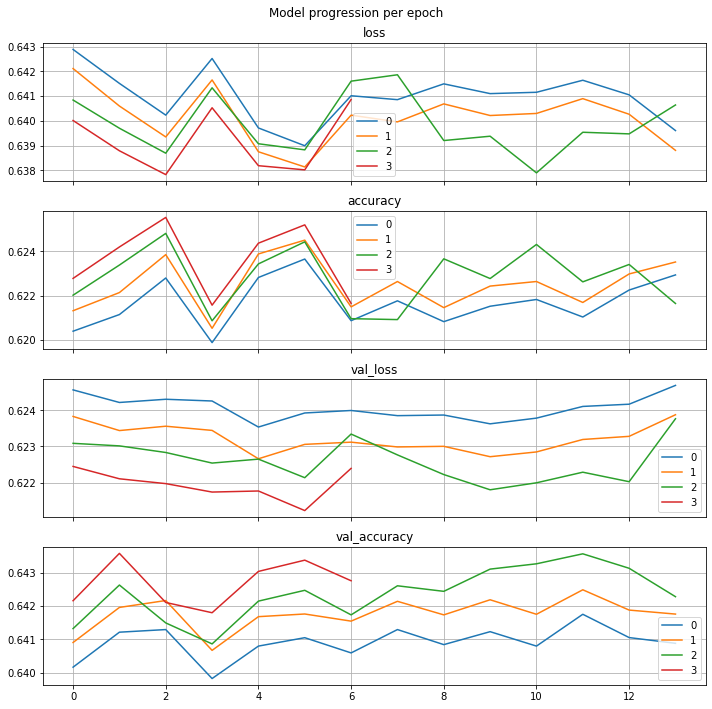

In [186]:
plot_epoch_subepoch_progression(metric_values_per_epoch, n_metrics=4, figsize=(10,10))

In [223]:
model_base_id = '327'
version = '9'
model_no = model_base_id
constituent_limits = 0.3
id_constituent = 1
min_vid_constituents = 0.8
epochs = 40
batch_size = 2048
load_dataset_wsd_ver_switcher = {'1':['1','world data load from test slice'],
                                 '2':['2','world data load from train slice'],
                                 '3':['3','validation data from test set'],}
load_dataset_wsd_ver = '3'
shuffle_buffer_size = 1
generator=True

ROOT_PATH='./'
DB_ROOT_PATH='E:\#PROJECT\idx'
db_ver = '8'

iter_id = f'{model_no}-{version}_cl-{constituent_limits}_idc-{id_constituent}_mid-{min_vid_constituents}_ep-{epochs}_bz-{batch_size}_ldtv-{load_dataset_wsd_ver_switcher[load_dataset_wsd_ver][0]}_sbuffs-{shuffle_buffer_size}_gen-{1 if generator else 0}'
histories = get_histories_by_iterid(ROOT_PATH, iter_id)
metric_values, xticklabels, metric_values_per_epoch = get_plot_axis_values(histories, metrics=('loss', 'accuracy'), sets=('', 'val_'))

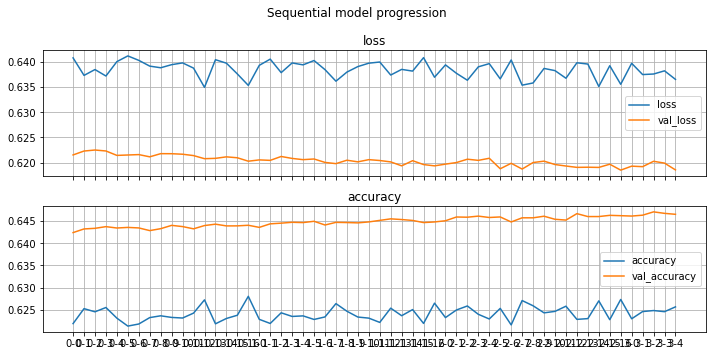

In [224]:
plot_sequential_model_progression(xticklabels, metric_values, subplots=2, figsize=(10,5))

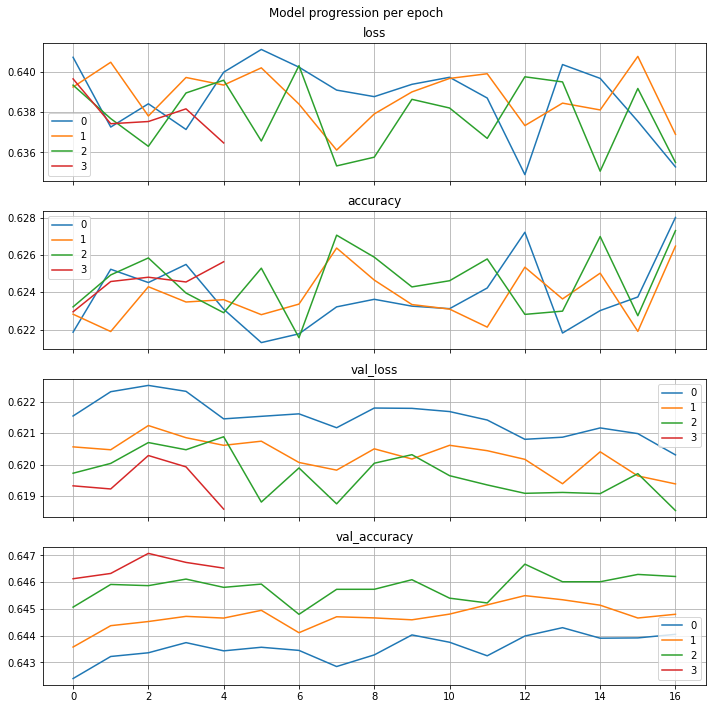

In [225]:
plot_epoch_subepoch_progression(metric_values_per_epoch, n_metrics=4, figsize=(10,10))